### Pytorch intro.

In [ ]:
import torch
scalar1=torch.tensor([1.])
scalar2=torch.tensor([3.])

In [ ]:
add_scalar=scalar1+scalar2
print(add_scalar)

tensor([4.])


In [ ]:
torch.add(scalar1, scalar2)

tensor([4.])

In [ ]:
vector1=torch.tensor([1.,2.,3.])
vector2=torch.tensor([4.,5.,6.])
add_vector=vector1+vector2
print(add_vector)

tensor([5., 7., 9.])


In [ ]:
torch.add(vector1,vector2)

tensor([5., 7., 9.])

In [ ]:
matrix1=torch.tensor([[1.,2.], [3.,4.]]) #2x2 matrix
matrix2=torch.tensor([[5.,6.], [7.,8.]]) 
add_matrix=matrix1+matrix2
print(add_matrix)

tensor([[ 6.,  8.],
        [10., 12.]])


## Simple deep learning model using pytorch

In [ ]:
import torch
if torch.cuda.is_available():
     DEVICE=torch.device("cuda")
else:
  DEVICE=torch.device("cpu")

In [ ]:
BATCH_SIZE=64
INPUT_SIZE=1000
HIDDEN_SIZE=100
OUTPUT_SIZE=10

In [ ]:
x=torch.randn(BATCH_SIZE, INPUT_SIZE, device=DEVICE, dtype=torch.float, requires_grad=False)
y=torch.randn(BATCH_SIZE, OUTPUT_SIZE, device=DEVICE, dtype=torch.float, requires_grad=False)
w1=torch.randn(INPUT_SIZE, HIDDEN_SIZE, device=DEVICE, dtype=torch.float, requires_grad=True)
w2=torch.randn(HIDDEN_SIZE, OUTPUT_SIZE, device=DEVICE, dtype=torch.float, requires_grad=True)

In [ ]:
learning_rate=1e-6
for t in range(1, 501):
    y_pred=x.mm(w1).clamp(min=0).mm(w2)

    loss=(y_pred-y).pow(2).sum()
    if t % 100 ==0:
      print("Iteration: ", t, "\t", "Loss: ", loss.item())
    loss.backward()

    with torch.no_grad():
         w1 -= learning_rate*w1.grad
         w2 -= learning_rate*w2.grad

         w1.grad.zero_()
         w2.grad.zero_()
#print(w1)
#print(w2)

Iteration:  100 	 Loss:  700.193359375
Iteration:  200 	 Loss:  4.718446731567383
Iteration:  300 	 Loss:  0.09066484868526459
Iteration:  400 	 Loss:  0.002726516919210553
Iteration:  500 	 Loss:  0.00023024133406579494


### Multi Layer Perceptron (MLP) using MNIST dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
BATCH_SIZE=32
EPOCHS=10

In [ ]:
train_dataset=datasets.MNIST(root="..", train=True, download=True, transform=transforms.ToTensor())
test_dataset=datasets.MNIST(root="..", train=False, download=True, transform=transforms.ToTensor())
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
for(X_train, y_train) in train_loader:
      print("X_train:", X_train.size(), "type:", X_train.type())
      print("y_train:", y_train.size(), "type:", y_train.type())
      break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


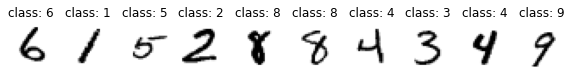

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
     plt.subplot(1, 10, i+1)
     plt.axis("off")
     plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap="gray_r")
     plt.title("class: "+ str(y_train[i].item()))

In [ ]:
class Net(nn.Module):

     def __init__(self):
         super(Net, self).__init__()
         self.fc1=nn.Linear(28*28, 512)
         self.fc2=nn.Linear(512,256)
         self.fc3=nn.Linear(256,10)
     def forward(self, x):
          x=x.view(-1,28*28)
          x=self.fc1(x)
          x=F.relu(x)
          x=self.fc2(x)
          x=F.relu(x)
          x=self.fc3(x)
          x=F.log_softmax(x, dim=1)
          return x

In [ ]:
model=Net().to(DEVICE)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion=nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
def train(model, train_loader, optimizer, log_interval):
     model.train()
     for batch_idx, (image, label) in enumerate(train_loader):
          image=image.to(DEVICE)
          label=label.to(DEVICE)
          optimizer.zero_grad()
          output=model(image)
          loss=criterion(output, label)
          loss.backward()
          optimizer.step()

          if batch_idx % log_interval==0:
               print("train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {: 6f}".format(Epoch, batch_idx*len(image), 
                  len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))

In [ ]:
def evaluate(model, test_loader):
     model.eval()
     test_loss=0
     correct=0

     with torch.no_grad():
          for image, label in test_loader:
              image=image.to(DEVICE)
              label=label.to(DEVICE)
              output=model(image)
              test_loss +=criterion(output, label).item()
              prediction= output.max(1, keepdim=True)[1]
              correct +=prediction.eq(label.view_as(prediction)).sum().item()
     test_loss /=len(test_loader.dataset)
     test_accuracy=100.*correct/len(test_loader.dataset)
     return test_loss, test_accuracy

In [ ]:
for Epoch in range(1, EPOCHS+1):
     train(model, train_loader, optimizer, log_interval=200)
     test_loss, test_accuracy=evaluate(model, test_loader)
     print("\n[EPOCH: {}],\tTest Loss: {:.4f}), \tTest Accuracy: {:.2f}%\n".format(Epoch, test_loss, test_accuracy))

train Epoch: 1 [0/60000(0%)]	Train Loss:  2.307264
train Epoch: 1 [6400/60000(11%)]	Train Loss:  1.921047
train Epoch: 1 [12800/60000(21%)]	Train Loss:  0.960290
train Epoch: 1 [19200/60000(32%)]	Train Loss:  0.598476
train Epoch: 1 [25600/60000(43%)]	Train Loss:  0.268459
train Epoch: 1 [32000/60000(53%)]	Train Loss:  0.377744
train Epoch: 1 [38400/60000(64%)]	Train Loss:  0.219995
train Epoch: 1 [44800/60000(75%)]	Train Loss:  0.317007
train Epoch: 1 [51200/60000(85%)]	Train Loss:  0.314062
train Epoch: 1 [57600/60000(96%)]	Train Loss:  0.419133

[EPOCH: 1],	Test Loss: 0.0096), 	Test Accuracy: 91.16%

train Epoch: 2 [0/60000(0%)]	Train Loss:  0.375586
train Epoch: 2 [6400/60000(11%)]	Train Loss:  0.304387
train Epoch: 2 [12800/60000(21%)]	Train Loss:  0.253235
train Epoch: 2 [19200/60000(32%)]	Train Loss:  0.221691
train Epoch: 2 [25600/60000(43%)]	Train Loss:  0.198669
train Epoch: 2 [32000/60000(53%)]	Train Loss:  0.176534
train Epoch: 2 [38400/60000(64%)]	Train Loss:  0.343378
tra

### keras code 1 

In [49]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [2]:
train_images.shape

(60000, 28, 28)

In [3]:
test_images.shape

(10000, 28, 28)

In [4]:
len(train_labels)

60000

In [5]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [6]:
from keras import models
from keras import layers
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

In [7]:
network.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [8]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [ ]:
!pip install keras.utils
import keras.utils

In [9]:
 from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [10]:
 network.fit(train_images, train_labels, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1896 - accuracy: 0.9431
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0947 - accuracy: 0.9745
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0750 - accuracy: 0.9806
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0651 - accuracy: 0.9842
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0573 - accuracy: 0.9865
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0524 - accuracy: 0.9882
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0464 - accuracy: 0.9897
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0438 - accuracy: 0.9908
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0380 - accuracy: 0.9922
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

In [11]:
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.2318 - accuracy: 0.9772
test_acc: 0.9771999716758728


### Keras code2

In [ ]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [50]:
valid_images, train_images=train_images[:5000]/255.0, train_images[5000:]/255.0
valid_labels, train_labels=train_labels[:5000], train_labels[5000:]
test_images=test_images/255.0

In [51]:
from keras import models
from keras import layers
network = models.Sequential()
network.add(layers.Flatten(input_shape=[28*28]))
network.add(layers.Dense(512, activation='relu'))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

In [52]:
network.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [53]:
network.layers

In [42]:
hidden1=network.layers[1]
hidden1.name

'dense_9'

In [43]:
weights, biases=hidden1.get_weights()
weights

array([[ 0.01849821, -0.06663666,  0.00192888, ...,  0.06622045,
         0.02369482, -0.06187632],
       [-0.06407128,  0.06064926, -0.00606798, ...,  0.05443891,
        -0.03029243,  0.04703661],
       [-0.05138426, -0.03913103, -0.0159838 , ...,  0.05260303,
         0.01453852,  0.01310901],
       ...,
       [ 0.05149112, -0.02226015, -0.06303842, ...,  0.01189462,
         0.01160786, -0.04169525],
       [-0.06431752,  0.0194836 ,  0.06202847, ..., -0.04459525,
         0.05706735,  0.01055623],
       [ 0.00263814, -0.02282318, -0.0141426 , ..., -0.06238539,
         0.03453089,  0.05463314]], dtype=float32)

In [44]:
weights.shape

(784, 512)

In [45]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [46]:
biases.shape

(512,)

In [54]:
network.compile(optimizer='rmsprop',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [55]:
history=network.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1988 - accuracy: 0.9407 - val_loss: 0.1196 - val_accuracy: 0.9652
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0957 - accuracy: 0.9736 - val_loss: 0.0998 - val_accuracy: 0.9754
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0763 - accuracy: 0.9804 - val_loss: 0.0820 - val_accuracy: 0.9820
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0644 - accuracy: 0.9837 - val_loss: 0.1059 - val_accuracy: 0.9776
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0538 - accuracy: 0.9868 - val_loss: 0.1209 - val_accuracy: 0.9816
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0466 - accuracy: 0.9886 - val_loss: 0.1360 - val_accuracy: 0.9790
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0437 - accuracy: 0.9900 - val_loss: 0.1580 - val_accuracy

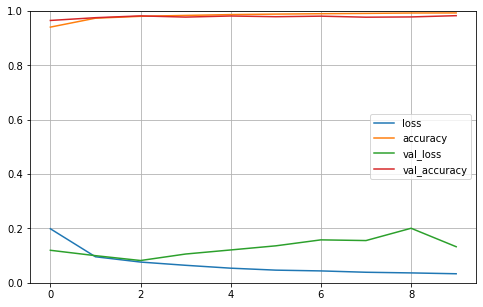

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


In [61]:
network.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.1593 - accuracy: 0.9804


[0.1592901200056076, 0.980400025844574]

In [65]:
image_new=test_images[:3]
predict_labels=network.predict(image_new)
predict_labels.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [67]:
test_labels[:3]

array([7, 2, 1], dtype=uint8)